In [1]:
using PyPlot, ForwardDiff, TaylorSeries, LinearAlgebra, Roots
function rescale!(x::Taylor1,lambda)
    mult = one(lambda);
    for i in 2:length(x.coeffs)
        mult /= lambda
        x.coeffs[i] *= mult
    end
    x
end
ForwardDiff.can_dual(::Type{Taylor1{Float64}}) = true
Base.isinteger(::Taylor1{Float64}) = false

PyObject <module 'matplotlib' from '/Users/caro/.julia/conda/3/lib/python3.7/site-packages/matplotlib/__init__.py'>

In [26]:
function truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100)
    # https://stackoverflow.com/a/18926541

    if isa(cmap, AbstractString)
        cmap = plt.get_cmap(cmap)
    end
    plt.matplotlib.colors.LinearSegmentedColormap.from_list(
        "trunc($cmap.name,$minval,$maxval)", 
        cmap(range(minval, stop=maxval, length=n))
        )
end

truncate_colormap (generic function with 4 methods)

In [31]:
truncate_colormap("plasma",0.4,1)

In [2]:
function sol(x,y) # well ok its not a solenoid any more
    1-1.8abs(x) + y, 0.35x
end
sol(x) = [sol(x...)...]

function invsol(x,y)
    y/0.35, x-(1-1.8*abs(y)/0.35)
end
invsol(x) = [invsol(x...)...]

function Jsol(x,y)
    [-1.8*sign(x) 1;0.35 0]
end
function Jinvsol(x,y)
    inv([-1.8*sign(y/0.35) 1;0.35 0])
end


Jinvsol (generic function with 1 method)

In [3]:
t = Taylor1(Float64,2)
(xsol,ysol) = 0.2rand(2) .+ t
# vusol = randn(2)+dualnum*randn(2)
for i = 1:10000
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
#     vusol = Jsol([xsol,ysol])*vusol; vusol /= norm(realpart.(vusol)) # to make make sense....
#     println(vusol)
end
N = 200_000
solh = Array{typeof(xsol)}(undef,N,2)
# vusolh = Array{Dual{Float64}}(undef,N,2)
lusolh = Array{Float64}(undef,N)
for i = 1:N
    (xsol,ysol) = sol(xsol,ysol); lusol = hypot(xsol[1],ysol[1])
    rescale!(xsol,lusol); rescale!(ysol,lusol)
    solh[i,1] = xsol; solh[i,2] = ysol
    lusolh[i] = lusol
end
dxdtnorm = sqrt.(differentiate.(solh[:,1]).^2 + differentiate.(solh[:,2]).^2)
rhograds = getindex.(1 ./dxdtnorm,1);

In [4]:
lsol = rand(2) .+ differentiate(t^2/2)
lsolh = Array{Taylor1{Float64}}(undef,N,2)
lsolh[N,:] = lsol
for i = N-1:-1:1
    lsol = Jsol(solh[i,1],solh[i,2])'*lsol; 
    lsol /= dot(differentiate.(solh[i,:])/dxdtnorm[i],lsol)
    lsolh[i,:] = lsol
    end
lnorms = vec(mapslices(x->norm(getcoeff.(x,0)),lsolh,dims=2))
dldt = getcoeff.(lsolh,1);

In [5]:
krhopart = rhograds.*getcoeff.(lsolh,0); krhonorms = abs.(rhograds) .* lnorms
kXnorms = lnorms;
klpart = dldt ./ getcoeff.(dxdtnorm,0); klnorms = vec(mapslices(norm,klpart,dims=2));

In [6]:
Xv = [ zeros(N) getcoeff.(solh[:,1],0)]
DXvxy = ones(N)
lrtdensity = vec(sum((krhopart + klpart).*Xv,dims=2) + 
    getcoeff.(lsolh[:,2],0).*(DXvxy.*getcoeff.(solh[:,1],1)./getcoeff.(dxdtnorm,0)));

In [7]:
function dotprods(x,y,fd=2,bw=1)
    Jfd = Matrix{promote_type(typeof(x),typeof(y))}(LinearAlgebra.I,2,2)
    xfd,yfd = x,y
    for i = 1:fd
        Jfd = Jsol(xfd,yfd)*Jfd
        xfd,yfd = sol(xfd,yfd)
    end
        Jbw = Matrix{promote_type(typeof(x),typeof(y))}(LinearAlgebra.I,2,2)
        xbw,ybw = x,y
    for i = 1:bw
#         bw = Jinvsol(xbw,ybw)*Jbw
        xbw,ybw = invsol(xbw,ybw)
        Jbw = Jsol(xbw,ybw)'*Jbw
    end
    effd = svd(Jfd); efbw = svd(Jbw)
#     println(effd.S,efbw.S)
    dt = 1-dot(effd.V[:,1],efbw.V[:,1])^2
#     imag(dt) > 1000eps(eltype(Jfd)) && error("Complex eigenvalues: $(effd.values) $(efbw.values)")
    

end

dotprods (generic function with 3 methods)

In [8]:
include("../simulations/cool-intervals.jl")
p = (1.8,0.35); T = Float64
# this should really be a cool_intervals_init function
# start with the backward-invariant unstable manifold between w_0 and w_1
beta = (p[1]-sqrt(p[1]^2+4p[2]))/2; alpha = -beta/(1+beta)
x_ref_end = -alpha/beta; x_ref_start = 1-p[1]*x_ref_end
Q = [1 -beta; beta 1]/sqrt(1+beta*beta)
Is = Q[2,:]*alpha .+ sqrt(1+beta*beta)*T.([1,0])*[x_ref_start x_ref_end]

# spinup
for i = 1:10000
    Is, Q, c, cw = cool_intervals(Is,Q,p)
end

ch = Array{Float64}(undef,1000)
vuh = Array{Float64}(undef,1000,2)
vu_perph = Array{Float64}(undef,1000,2)
for i = 1:1000
    vuh[i,:] = Q[:,1]
    vu_perph[i,:] = Q[:,2]
    Is, Q, c, cw = cool_intervals(Is,Q,p)
    ch[i] = c
end

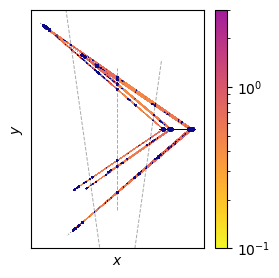

1.3598002073001698
0.2878359373548226
0.06341499474789854
0.014050390194107084
0.003115509163629115
0.0006909045455273168
0.0001532194374891461
3.3979003036026265e-5
7.535421242950753e-6
1.6711077636386538e-6


In [38]:
exes = 0.67:0.001:1.25;
wyes_tang = zeros(size(exes))
thecolormap = matplotlib.cm.get_cmap("plasma_r")
figure(figsize=(2.88,2.88))
# imshow(log10.(1 .-dotprodmat'),extent=(extrema(exes)...,reverse(extrema(wyes))...)); #colorbar()
scatter(map.(solh[:,1],0),map.(solh[:,2],0),c=abs.(lrtdensity),marker=".",s=0.5,linewidth=0,
    norm=matplotlib.colors.LogNorm(vmin=1e-1, vmax=3e0),
    cmap=truncate_colormap(thecolormap,0,0.65),zorder=3)
colorbar()
tangline0 = [exes wyes_tang]#(0.5:0.0003:1.5).*[1 0.0]
tangline = copy(tangline0)

# forward iterates
cfwd = [fill(eps(),size(ch)) ch]
vufwd = copy(vuh)
for m = 1:10
    for i in 1:size(vufwd,1)
        vufwd[i,:] = Jsol(cfwd[i,:]...)*vufwd[i,:];
        if m == 1
            vufwd[i,:] /= norm(vufwd[i,:])
        end
        cfwd[i,:] .= sol(cfwd[i,:]...)
    end
    markersizes = 8 ./(vec(mapslices(norm,vufwd,dims=2))); markersizes[isnan.(markersizes)] .= 0
#     println(maximum(markersizes))
    scatter(cfwd[:,1],cfwd[:,2],ec="none",c=[[thecolormap(1.0)...]';],s=markersizes,zorder=3)
end
    
# backward iterates
cbwd = [(1 .+ ch) fill(eps(),size(ch))]
vsbwd = [zeros(size(ch)) ones(size(ch))]
for m = 1:10
#         println(atan.(vsbwd[:,1],vsbwd[:,2])/pi)
    for i in 1:size(vsbwd,1)
        vsbwd[i,:] = Jinvsol(cbwd[i,:]...)*vsbwd[i,:]
        cbwd[i,:] .= invsol(cbwd[i,:]...)
    end
    
    markersizes = 8 ./(vec(mapslices(norm,vsbwd,dims=2))); markersizes[isnan.(markersizes)] .= 0
#     figure(3); hist(log10.(markersizes),-16:0.25:1); figure(1)

    println(maximum(markersizes))
    scatter(cbwd[:,1],cbwd[:,2],ec="none",c=[[thecolormap(1.0)...]';],s=markersizes,zorder=3)
end


for i = 1:2
    tangline = mapslices(sol,tangline,dims=2)
    plot(tangline[:,1], tangline[:,2],zorder=1,c="gray",":",linewidth=0.7)
end

tangline = copy(tangline0)
for i = 1:2
    tangline = mapslices(invsol,tangline,dims=2)
    plot(tangline[:,1], tangline[:,2],zorder=1,c="darkgray","--",linewidth=0.7)
end
plot(tangline0[:,1], tangline0[:,2],zorder=1,c="k",linewidth=0.7)

xlim(-1.4,1.4);ylim(-1.4*0.35,1.4*0.35)
xticks([]);yticks([])
xlabel("\$x\$");ylabel("\$y\$")
tight_layout()
savefig("../figures/Spaghetti-Lozi.png",dpi=500)

In [111]:
vsbwd = [zeros(size(ch)) ones(size(ch))]
atan(vsbwd[1,1],vsbwd[1,2])

0.0